In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu

In [2]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'SWISS_MaleUrine_Exposure'
subjects = ace.list_subjects(root_directory)
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'

In [3]:
# Take the SW > 19
subjects = [sub for sub in subjects if sub[0:2]=='SW' and int(sub[2:].split('_')[0]) in set(range(19,36))]

In [4]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [5]:
def load_subject(subject):
    df_mouse = pd.read_csv(data_directory + subject + '/cells150_10-10.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

# Analysis on SWISS 19-35 with father : threshold 300

In [6]:
# NB: Run only if file does not exist or needs to be regenerated
dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject), 
                                                                          vol=volumes, 
                                                                          level=8) for subject in subjects}
np.save('dict_results/dict_results_across_mice_SW19-35-150_10-10.npy', dict_results_across_mice)

/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/pytho

In [7]:
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_SW19-35-150_10-10.npy', allow_pickle=True).item()

In [8]:
# removed key corresponding to SW21_Fam
dict_results_across_mice.pop('SW21_Fam')
subjects.remove('SW21_Fam')

# List areas with null cell count

In [9]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}

# List areas with no volume

In [10]:
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}

# Divide mice into experimental groups: FAM/UNFAM/CONTROL

In [11]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
experimental_groups

{'Control': ['SW25_Control',
  'SW19_Control',
  'SW24_Control',
  'SW31_Control',
  'SW30_Control'],
 'Unfam': ['SW26_Unfam',
  'SW20_Unfam',
  'SW22_Unfam',
  'SW28_Unfam',
  'SW34_Unfam',
  'SW32_Unfam'],
 'Fam': ['SW27_Fam', 'SW23_Fam', 'SW29_Fam', 'SW33_Fam', 'SW35_Fam']}

# Calculate cell count across experimental groups

In [12]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

## Calculate t-tests across groups per area

In [13]:
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.124561,0.473867,0.238097
1,Primary motor area,0.381522,0.677037,0.432625
2,Secondary motor area,0.309345,0.70009,0.312407
3,Primary somatosensory area,0.177696,0.606803,0.122296
4,Supplemental somatosensory area,0.187567,0.735301,0.111839
...,...,...,...,...
194,Interfascicular nucleus raphe,0.160647,0.0841371,0.708171
195,Interpeduncular nucleus,0.392252,0.296065,0.947062
196,Rostral linear nucleus raphe,0.443017,0.601586,0.578431
197,Central linear nucleus raphe,0.157443,0.299132,0.53294


In [14]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [15]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Ventral premammillary nucleus,1.91489e-05
Posterior amygdalar nucleus,0.000814018
Medial amygdalar nucleus,0.0012157
Submedial nucleus of the thalamus,0.011654
Parastrial nucleus,0.0125337
Central amygdalar nucleus,0.0219053
Vascular organ of the lamina terminalis,0.0451987
Posterior limiting nucleus of the thalamus,0.0559824
Pretectal region,0.0574004


In [16]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Posterior amygdalar nucleus,0.00170609
Medial amygdalar nucleus,0.00197877
Ventral premammillary nucleus,0.00219091
Accessory olfactory bulb,0.00960404
Submedial nucleus of the thalamus,0.0372158
Preparasubthalamic nucleus,0.0372547
Infralimbic area,0.0484909
Ventral tegmental area,0.0562352
Paraventricular hypothalamic nucleus,0.0818803


In [17]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Dorsal auditory area,0.0267839
Paraventricular hypothalamic nucleus descending division,0.0296191
Taenia tecta,0.0509294
Superior colliculus sensory related,0.0581218
Central amygdalar nucleus,0.0622432
Septohippocampal nucleus,0.0633944
Caudoputamen,0.0744077
Preparasubthalamic nucleus,0.0851506
Reticular nucleus of the thalamus,0.0866536


## Mann Whitney Test for comparison across groups

In [18]:
df_mannwhitneyu_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count,
                                           test='mannwhitneyu')
df_mannwhitneyu_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.0712283,0.261408,0.205124
1,Primary motor area,0.201698,0.463632,0.117667
2,Secondary motor area,0.338052,0.463632,0.157651
3,Primary somatosensory area,0.148135,0.392096,0.0603454
4,Supplemental somatosensory area,0.148135,0.463632,0.0854518
...,...,...,...,...
194,Interfascicular nucleus raphe,0.0806188,0.0463003,0.35719
195,Interpeduncular nucleus,0.417266,0.205657,0.463632
196,Rostral linear nucleus raphe,0.362041,0.227386,0.425881
197,Central linear nucleus raphe,0.201698,0.324038,0.392096


In [19]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [20]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Ventral premammillary nucleus,0.00609289
Medial amygdalar nucleus,0.00609289
Parastrial nucleus,0.00609289
Posterior amygdalar nucleus,0.00609289
Submedial nucleus of the thalamus,0.0105883
Posterior limiting nucleus of the thalamus,0.0136642
Central amygdalar nucleus,0.0300514
Infralimbic area,0.0300514
Vascular organ of the lamina terminalis,0.0453442


In [21]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Ventral premammillary nucleus,0.00405656
Posterior amygdalar nucleus,0.00405656
Medial amygdalar nucleus,0.00405656
Accessory olfactory bulb,0.0112394
Preparasubthalamic nucleus,0.0174631
Parastrial nucleus,0.033632
Ventral tegmental area,0.0400211
Anterior olfactory nucleus,0.0414187
Medial preoptic nucleus,0.0414187


In [22]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:35].set_index('area')

,pval_Fam_vs_Unfam
area,
Dorsal auditory area,0.0112394
Paraventricular hypothalamic nucleus descending division,0.0178819
Central amygdalar nucleus,0.0178819
Septohippocampal nucleus,0.026239
Piriform area,0.0276171
Triangular nucleus of septum,0.033632
Peripeduncular nucleus,0.0396718
Basolateral amygdalar nucleus,0.0414187
Anterior olfactory nucleus,0.0414187


## Calculate cross corr across groups per area on cell count

In [23]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

## Plot cross corr matrix across groups per area on cell count

Text(0.5, 1.0, 'CONTROL')

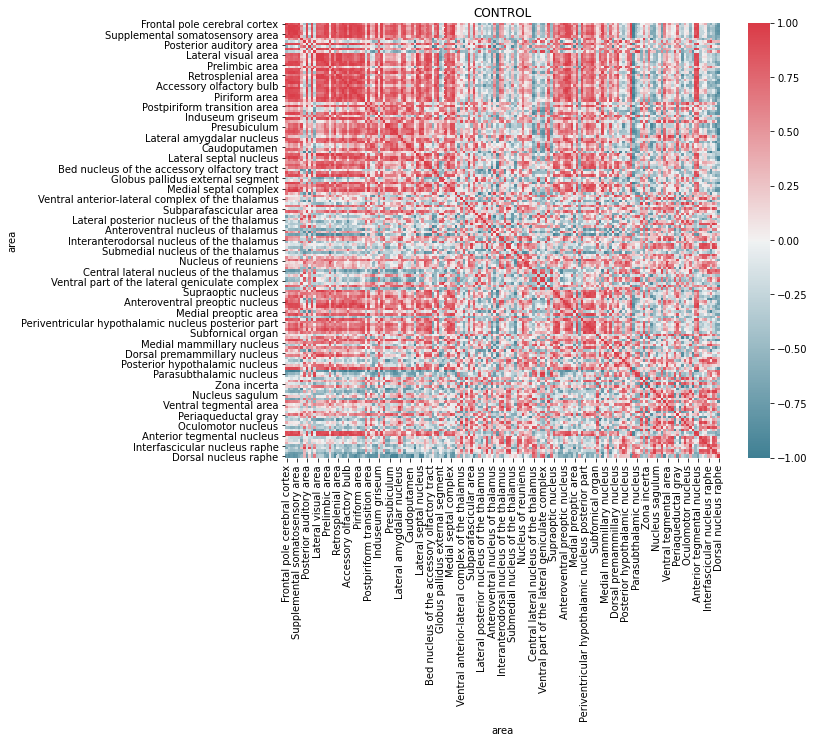

In [24]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

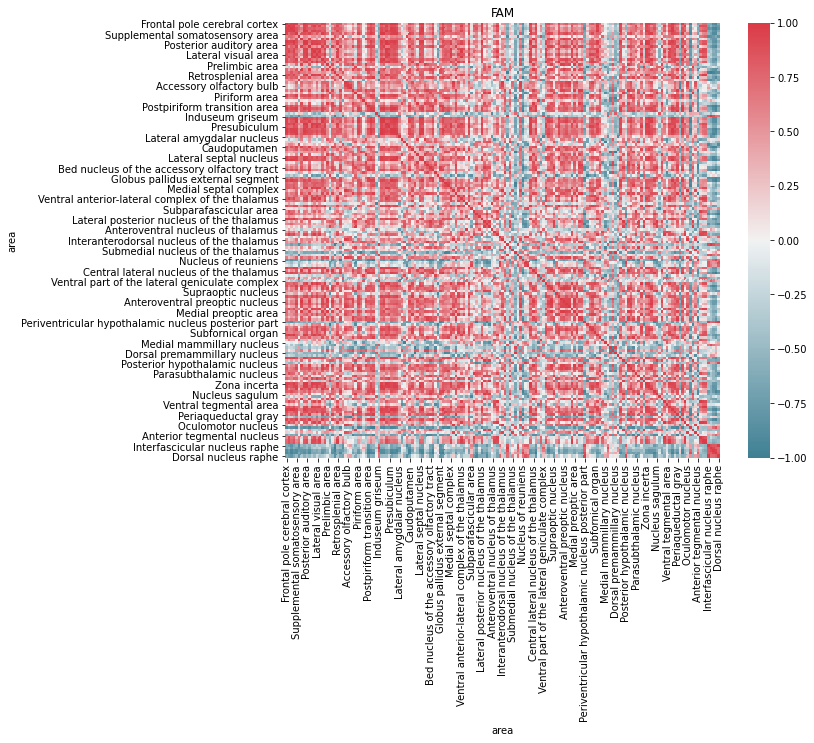

In [25]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

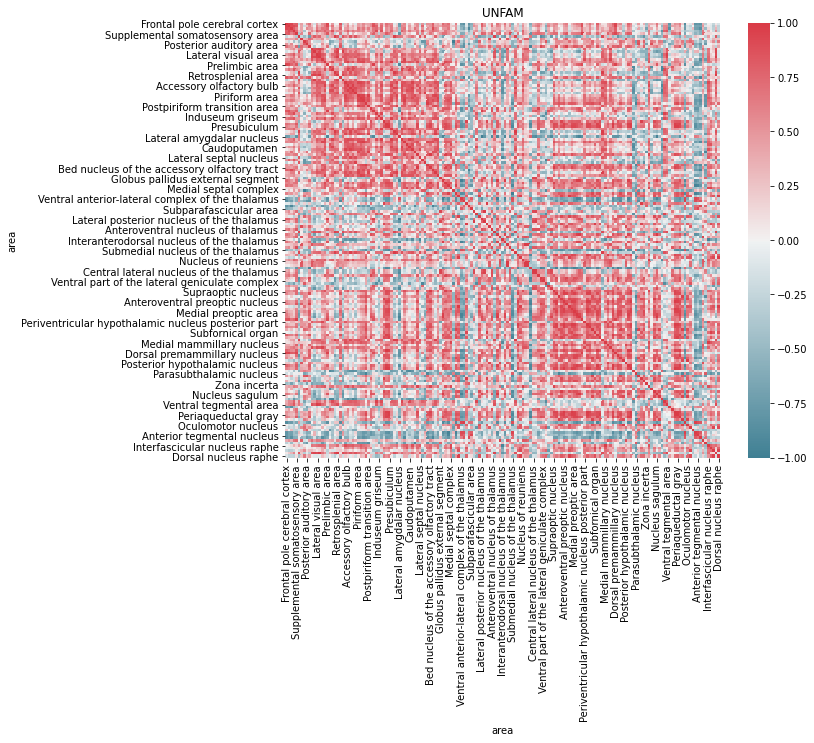

In [26]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

# Calculate energy across experimental groups

In [27]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

## T-test on energy across groups

In [28]:
df_ttest_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy)

In [29]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [30]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Ventral premammillary nucleus,1.66977e-05
Medial amygdalar nucleus,0.00234457
Posterior amygdalar nucleus,0.00240397
Submedial nucleus of the thalamus,0.0104338
Parastrial nucleus,0.0159625
Central amygdalar nucleus,0.0517627
Vascular organ of the lamina terminalis,0.0534573
Pretectal region,0.059264
Posterior limiting nucleus of the thalamus,0.0790784


In [31]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Medial amygdalar nucleus,0.00135175
Ventral premammillary nucleus,0.00204611
Posterior amygdalar nucleus,0.00241876
Accessory olfactory bulb,0.0223583
Submedial nucleus of the thalamus,0.0277935
Bed nucleus of the anterior commissure,0.045417
Preparasubthalamic nucleus,0.0457001
Infralimbic area,0.0549856
Ventral tegmental area,0.066958


In [32]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Dorsal auditory area,0.0311978
Paraventricular hypothalamic nucleus descending division,0.0395768
Bed nucleus of the anterior commissure,0.0544295
Septohippocampal nucleus,0.0646052
Superior colliculus sensory related,0.0702436
Reticular nucleus of the thalamus,0.0812111
Submedial nucleus of the thalamus,0.083788
Lateral amygdalar nucleus,0.101506
Preparasubthalamic nucleus,0.104231


## Mann-Whitney Test across groups

In [33]:
df_mannwhitneyu_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy,
                                    test='mannwhitneyu')

In [34]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_energy = df_mannwhitneyu_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [35]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:40].set_index('area')

,pval_Control_vs_Fam
area,
Anterior hypothalamic area,0.00609289
Ventral premammillary nucleus,0.00609289
Retroethmoid nucleus,0.00609289
Suprachiasmatic preoptic nucleus,0.00609289
Posterior amygdalar nucleus,0.00609289
Substantia nigra lateral part,0.00609289
Lateral strip of striatum,0.00609289
Intercollicular nucleus,0.00609289
Pineal body,0.00609289


In [36]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:50].set_index('area')

,pval_Control_vs_Unfam
area,
Anterior hypothalamic area,0.00405656
Posterior amygdalar nucleus,0.00405656
Intercollicular nucleus,0.00405656
Ventral premammillary nucleus,0.00405656
Lateral strip of striatum,0.00405656
Retroethmoid nucleus,0.00405656
Suprachiasmatic preoptic nucleus,0.00405656
Medial amygdalar nucleus,0.00405656
Substantia nigra lateral part,0.00405656


In [37]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Control_vs_Fam']][0:50].set_index('area')

,pval_Control_vs_Fam
area,
Lateral strip of striatum,0.00609289
Pineal body,0.00609289
Nucleus circularis,0.00609289
Retroethmoid nucleus,0.00609289
Suprachiasmatic preoptic nucleus,0.00609289
Substantia nigra lateral part,0.00609289
Intercollicular nucleus,0.00609289
Anterior hypothalamic area,0.00609289
Dorsal auditory area,0.148135


## Calculate cross corr matrix across experimental groups on energy

In [38]:
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

## Plot cross corr matrix across groups per area on energy

Text(0.5, 1.0, 'CONTROL')

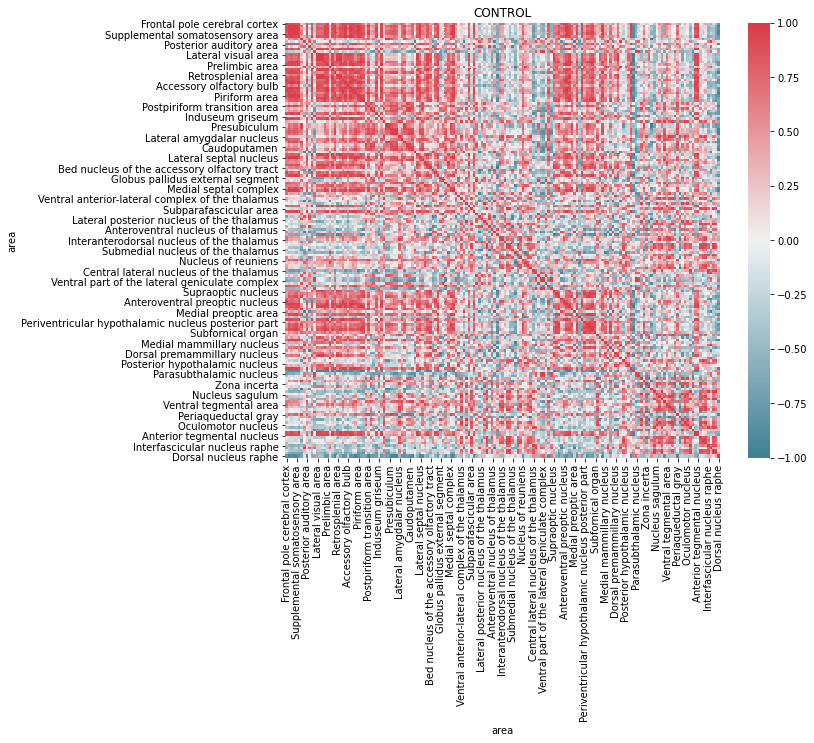

In [39]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

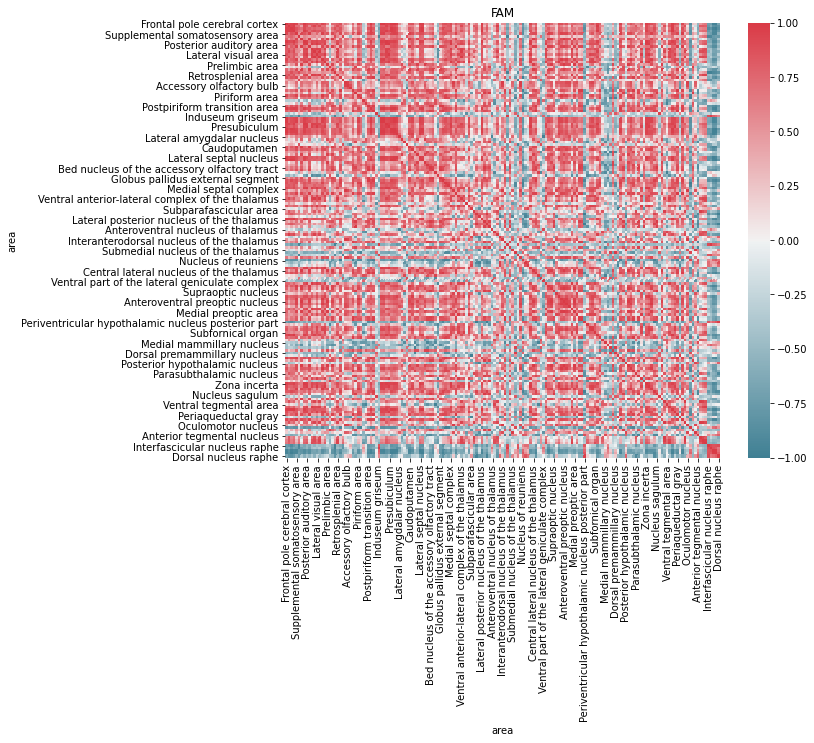

In [40]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

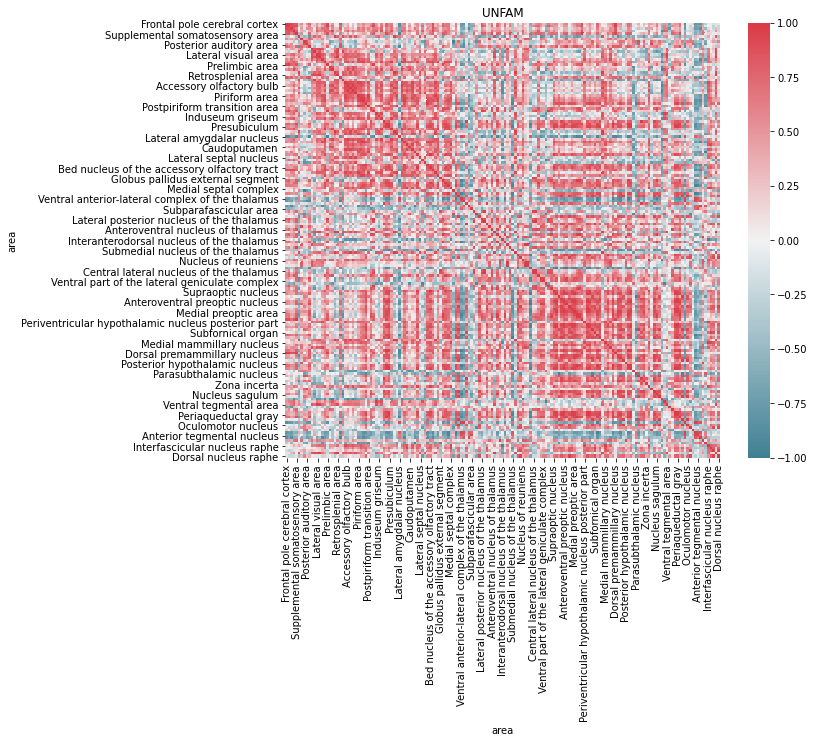

In [41]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')